# Alzheimer's Detection  
  
**DATA:**  
  
The data consists of 6400 MRI images. There are four classes of images both in training as well as a testing set:  
1. Mild Demented  
2. Moderate Demented  
3. Non Demented  
4. Very Mild Demented  
  
  
  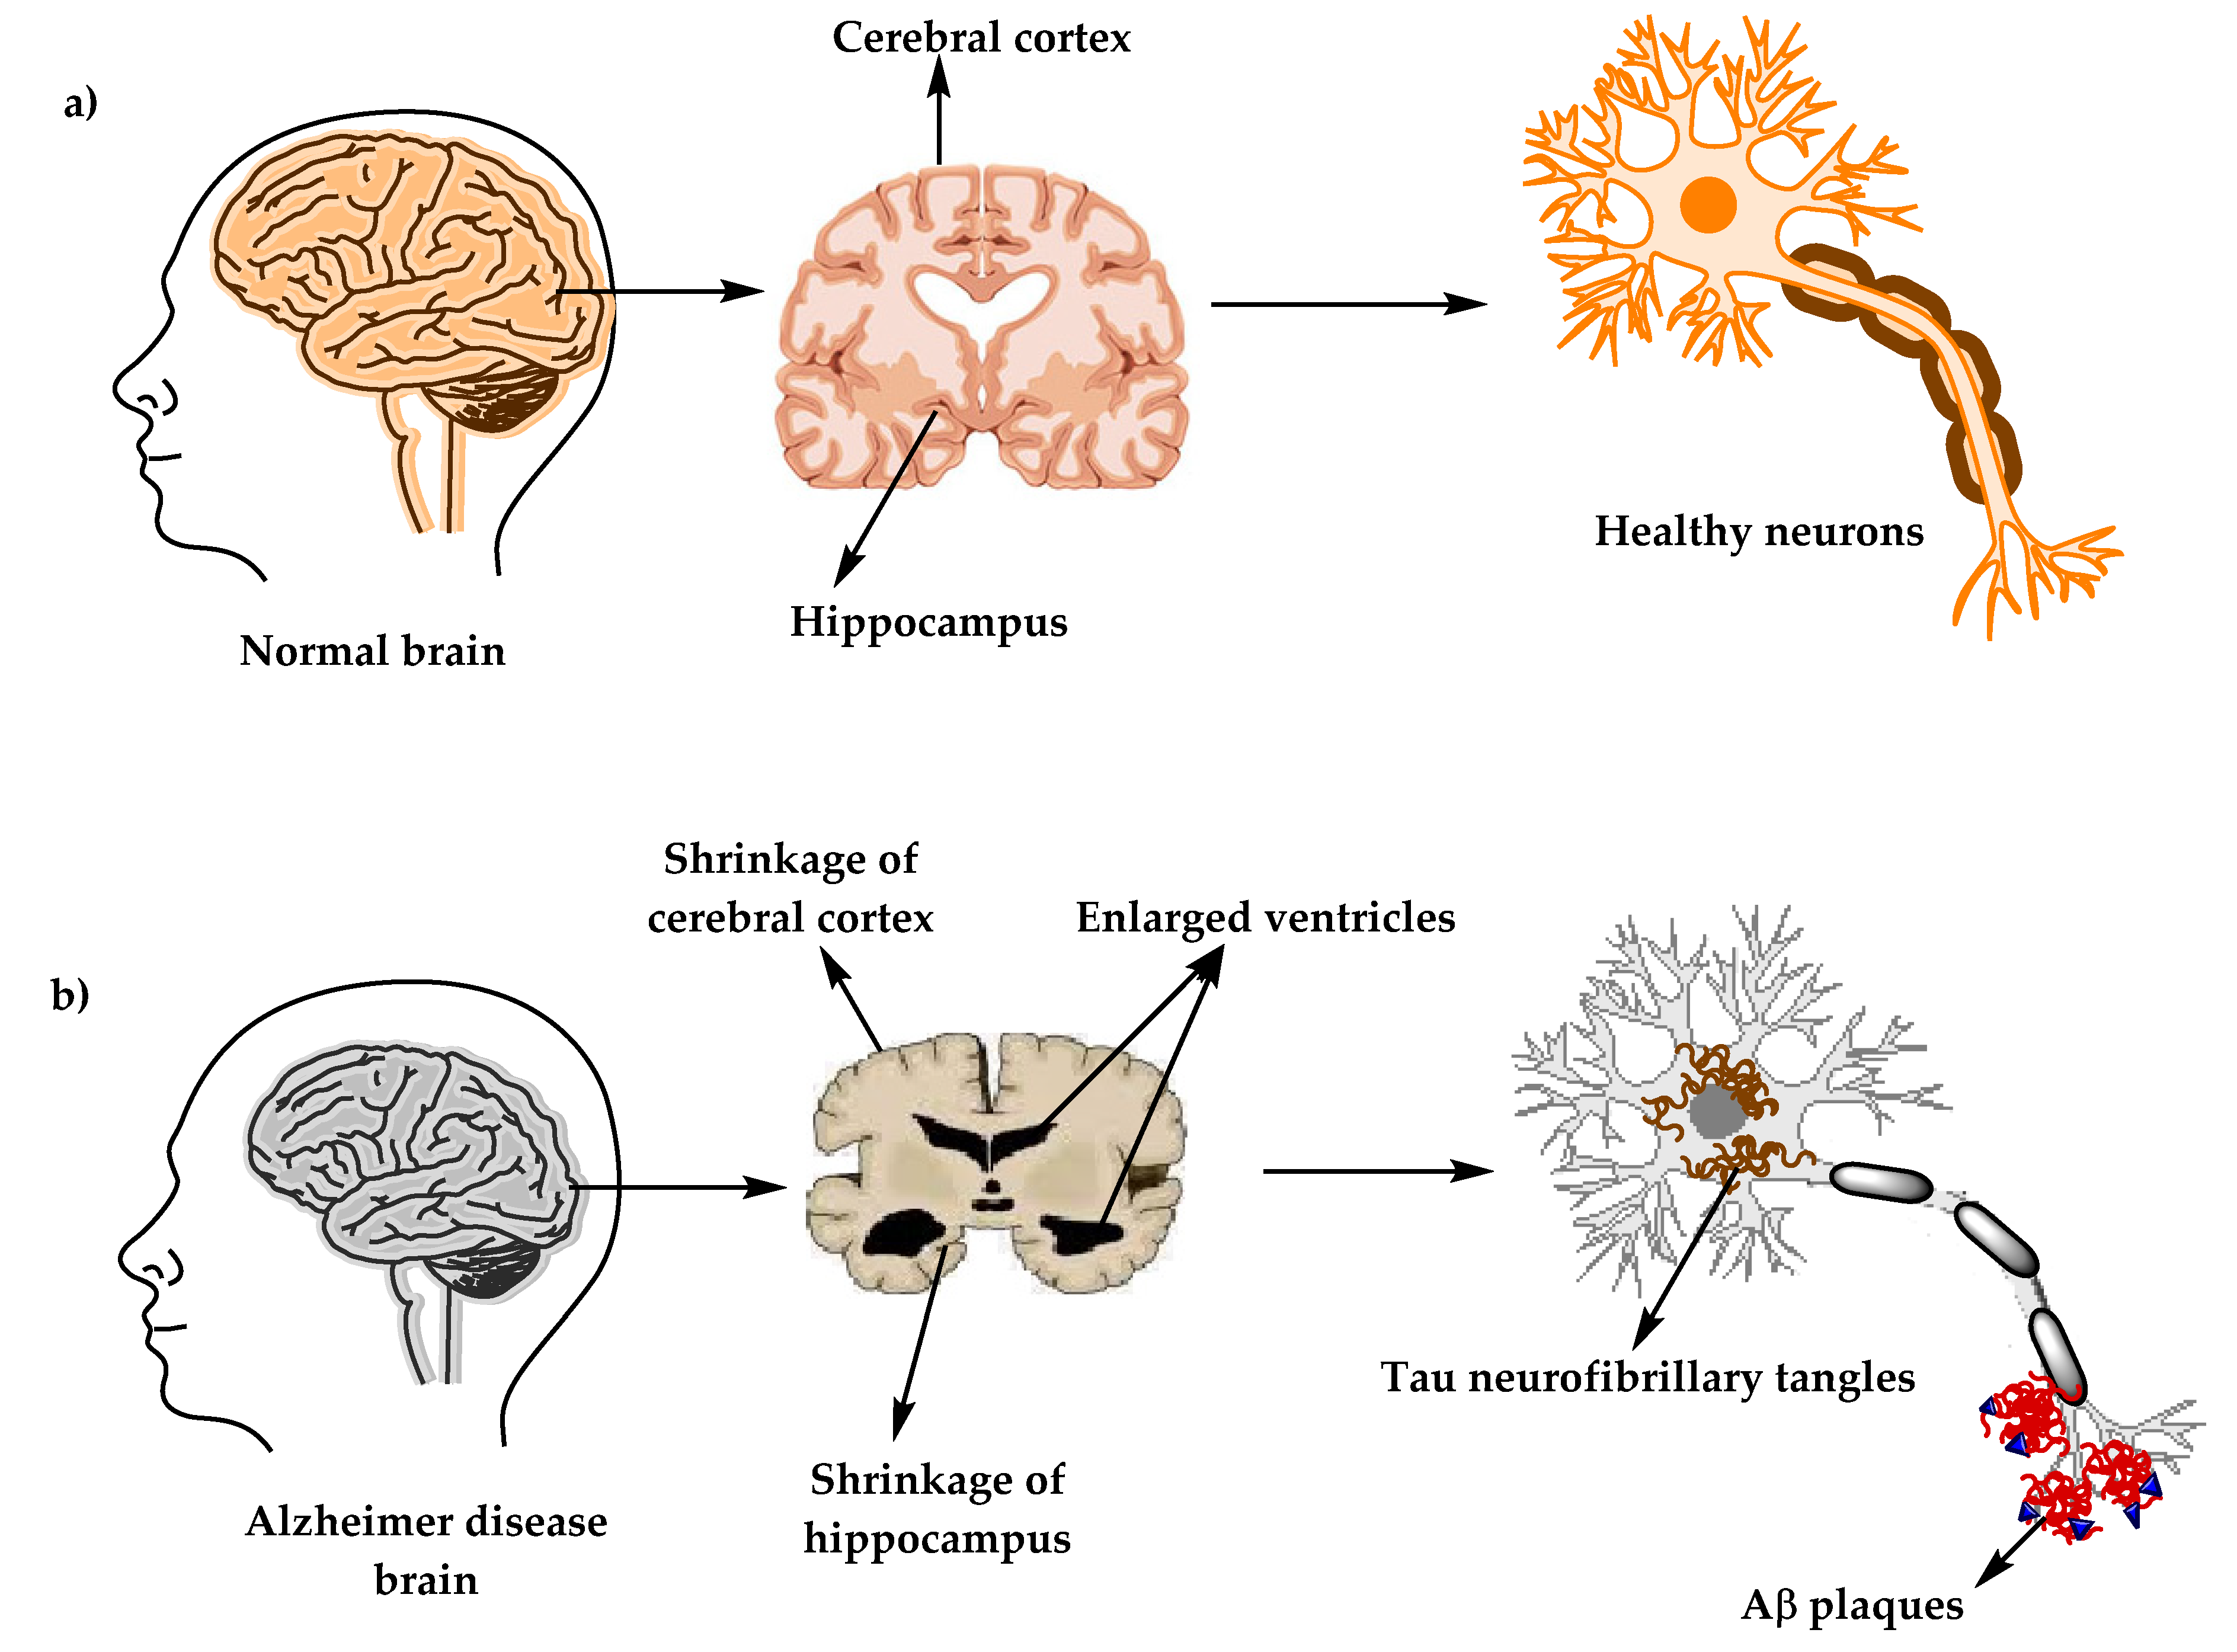
  
**AIM:**  
  
To identify and predict the Alzheimer’s disease diagnosis (i.e., the stage of disease progression) based on MRI images. 

  
**MODEL:**  

  
**CNN:**  

A Convolutional Neural Network (CNN/ConvNet) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.   



In [1]:
#Importing Required Libraries  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
! pip install nilearn
! pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 12.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 192 kB/s 


In [3]:
! pip install tensorflow_addons
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 28.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Importing libraries for pre-processing
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import image
import SimpleITK as sitk
from skimage import filters
import SimpleITK as sitk
from nilearn.image import math_img
from nilearn import image as nii
from nilearn import plotting
import cv2
import itertools
import pathlib
import warnings
import splitfolders
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree


In [5]:
#Uploading required file
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Upload from kaggle
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

 73% 25.0M/34.1M [00:00<00:00, 72.8MB/s]
100% 34.1M/34.1M [00:00<00:00, 76.9MB/s]


In [7]:
#Unzip
! unzip alzheimers-dataset-4-class-of-images

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [8]:
#Split data
splitfolders.ratio('Alzheimer_s Dataset/train', output="output",ratio=(.8, 0.1, 0.1))

Copying files: 5121 files [00:00, 7732.28 files/s]


In [9]:
#Train, Test and Validation set
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_df = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)


val_df = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)


Found 4095 files belonging to 4 classes.
Found 511 files belonging to 4 classes.
Found 515 files belonging to 4 classes.


In [10]:
#Classes
class_names = train_df.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


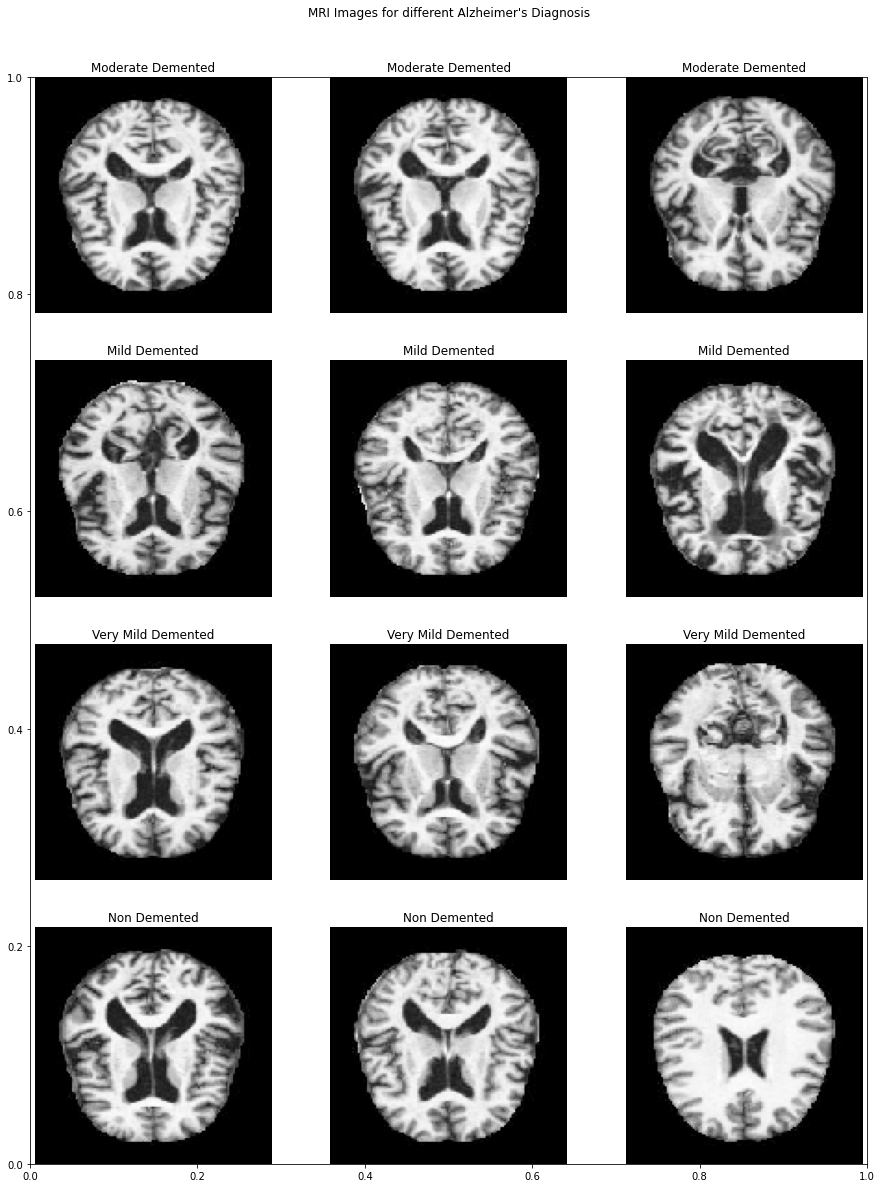

In [11]:
#Display Images
train_dir = 'output/train' # image folder

#Get list of images from sub-class folders
mdd = [fn for fn in os.listdir(f'{train_dir}/ModerateDemented') if fn.endswith('.jpg')]
mld = [fn for fn in os.listdir(f'{train_dir}/MildDemented') if fn.endswith('.jpg')]
vmd = [fn for fn in os.listdir(f'{train_dir}/VeryMildDemented') if fn.endswith('.jpg')]
nnd = [fn for fn in os.listdir(f'{train_dir}/NonDemented') if fn.endswith('.jpg')]

#Randomly select 3 from each class
smdd = np.random.choice(mdd, 3, replace = False)
smld = np.random.choice(mld, 3, replace = False)
svmd = np.random.choice(vmd, 3, replace = False)
snnd = np.random.choice(nnd, 3, replace = False)

#Plot 4x3 image matrix
fig = plt.figure(figsize = (15,20))
plt.title("MRI Images for different Alzheimer's Diagnosis", y=1.05)
for i in range(12):
    if i < 3:
        fp = f'{train_dir}/ModerateDemented/{smdd[i]}'
        label = 'Moderate Demented'
    elif i >= 3 and i < 6:
        fp = f'{train_dir}/MildDemented/{smld[i-3]}'
        label = 'Mild Demented'
    elif i >= 6 and i < 9:
        fp = f'{train_dir}/VeryMildDemented/{svmd[i-6]}'
        label = 'Very Mild Demented'
    elif i >= 9 and i < 12:
        fp = f'{train_dir}/NonDemented/{snnd[i-9]}'
        label = 'Non Demented'
    ax = fig.add_subplot(4, 3, i+1)
    
    #To plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (128,128), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [12]:
#Count of files for different classes
print("Moderate Demented : ", len(mdd))
print("Mild Demented : ", len(mld))
print("Very Mild Demented : ", len(vmd))
print("Non Demented : ", len(nnd))

Moderate Demented :  41
Mild Demented :  573
Very Mild Demented :  1433
Non Demented :  2048


In [13]:
#Representing images as matrices
def imgtmx(pt, ls, size = (64, 64)):
    #Iterate each file
    for fn in ls:
        fp = pt + fn
        cr = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        #Covert image to a matrix
        img_ts = image.img_to_array(cr)
        #Convert to vector (1D array)
        img_ts = [img_ts.ravel()]
        try:
            #Concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            #If not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [14]:
#Run function
md = imgtmx(f'{train_dir}/ModerateDemented/', mdd)
ld = imgtmx(f'{train_dir}/MildDemented/', mld)
vd = imgtmx(f'{train_dir}/VeryMildDemented/', vmd)
nd = imgtmx(f'{train_dir}/NonDemented/', nnd)

In [15]:
#Find Average Image
def avgimg(fm, title, size = (64, 64)):
    #Calculate the average
    mi = np.mean(fm, axis = 0)
    #Reshape to a matrix
    mi = mi.reshape(size)
    plt.imshow(mi, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mi

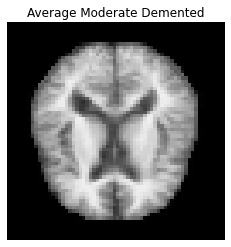

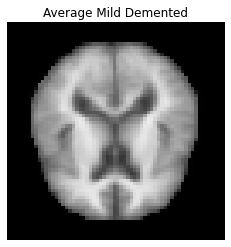

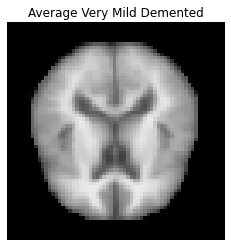

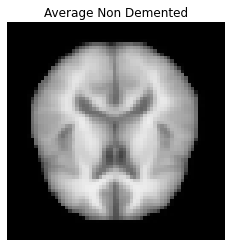

In [16]:
#Run function
mda = avgimg(md, 'Moderate Demented')
lda = avgimg(ld, 'Mild Demented')
vda = avgimg(vd, 'Very Mild Demented')
nda = avgimg(nd, 'Non Demented')

In [17]:
#Define the model
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [18]:
#Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [19]:
#Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [20]:
#Fit the model
history = model.fit(train_df,validation_data=val_df,epochs=100, batch_size=32, verbose=1)

Epoch 1/100
64/64 [==============================] - 15s 50ms/step - loss: 1.1888 - accuracy: 0.4940 - val_loss: 0.9483 - val_accuracy: 0.5910
Epoch 2/100
64/64 [==============================] - 3s 44ms/step - loss: 0.9261 - accuracy: 0.5582 - val_loss: 0.9239 - val_accuracy: 0.5910
Epoch 3/100
64/64 [==============================] - 3s 45ms/step - loss: 0.8284 - accuracy: 0.6173 - val_loss: 0.8053 - val_accuracy: 0.6419
Epoch 4/100
64/64 [==============================] - 3s 43ms/step - loss: 0.7691 - accuracy: 0.6513 - val_loss: 0.7131 - val_accuracy: 0.6967
Epoch 5/100
64/64 [==============================] - 3s 42ms/step - loss: 0.6557 - accuracy: 0.7194 - val_loss: 0.6862 - val_accuracy: 0.7221
Epoch 6/100
64/64 [==============================] - 3s 42ms/step - loss: 0.5551 - accuracy: 0.7656 - val_loss: 0.4922 - val_accuracy: 0.8004
Epoch 7/100
64/64 [==============================] - 3s 42ms/step - loss: 0.4345 - accuracy: 0.8256 - val_loss: 0.5227 - val_accuracy: 0.7613
Epoch

In [21]:
#Accuracy and loss
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

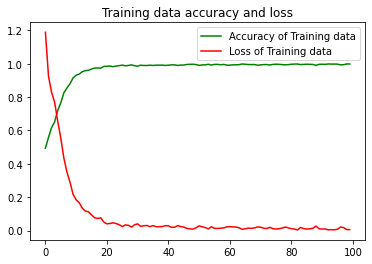

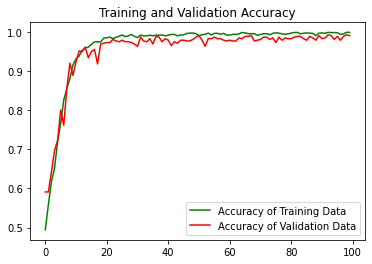

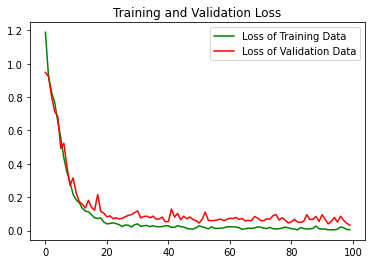

<Figure size 432x288 with 0 Axes>

In [22]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [23]:

loss, accuracy = model.evaluate(test_df)

9/9 [==============================] - 0s 19ms/step - loss: 0.0210 - accuracy: 0.9922


1/1 [==============================] - 0s 17ms/step


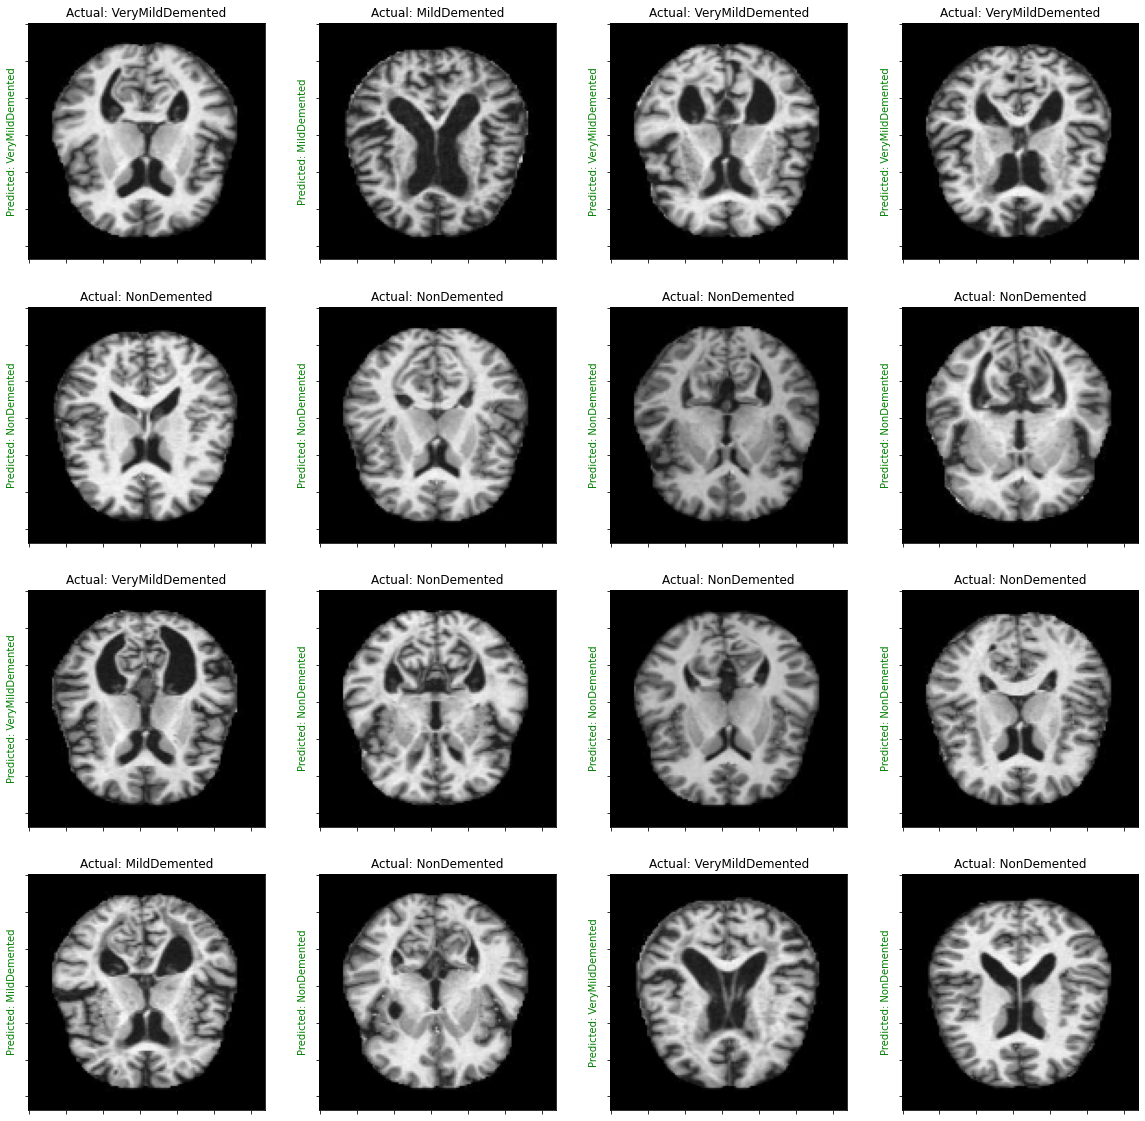

In [24]:
plt.figure(figsize=(20, 20))
for images, labels in test_df.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])